In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
#import os.path
#import cmath 
#import xarray as xr

- The data was copied from /work/ollie/gallen/data_4_TR/

- 6 experiments:
LGM  ORB002  ORB006  ORB02lgm  ORB06lgm  PI

- For each experiment, there is:
- U10 and V10 in xxx_u10_v10_ymonmean_r360x180.nc
- T (VAR: THO), S (VAR: SAO), Sea ice (Var: SICOMO) and SSH (Var: ZO) in xxx_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc
- OCN-U and OCN-V in xxx_UKOandVKE_ymonmean_UVrotated_r360x180.nc

- 2 more experiments from /work/ba0989/a270078/Data_for_ThomasR/LGM27ka and /work/ba0989/a270078/Data_for_ThomasR/LGM28p7 (28.7ka orbital configuration, in which the summer insolation over Southern Ocean is close its minimum in the last 40ka)

- updates in /work/ba0989/a270078/Data_for_ThomasR/PI+LGM , /work/ba0989/a270078/Data_for_ThomasR/LGM27ka, /work/ba0989/a270078/Data_for_ThomasR/LGM28p7

In [2]:
ls

LGM/
LGM27ka/
LGM28p7/
LGM_awicm/
LGM_toXun.png
LGM_update/
ORB002/
ORB006/
ORB02lgm/
ORB05lgm/
ORB06lgm/
PI/
PI_awicm/
PI_toXun.png
PI_update/
README.md
Wesche-Dierking_2015.csv
pyberg_standalone.ipynb
pyberg_standalone_classes.ipynb
pyberg_standalone_classes_LGM.ipynb
pyberg_standalone_classes_NEW_LGM.ipynb
pyberg_standalone_classes_NEW_LGM_ORB002.ipynb
pyberg_standalone_classes_NEW_LGM_ORB006.ipynb
pyberg_standalone_classes_NEW_LGM_ORB02lgm.ipynb
pyberg_standalone_classes_NEW_LGM_ORB05lgm.ipynb
pyberg_standalone_classes_NEW_LGM_ORB06lgm.ipynb
pyberg_standalone_classes_NEW_PI.ipynb
pyberg_standalone_classes_WescheDierking_PI-LGM27ka.ipynb
pyberg_standalone_classes_WescheDierking_PI-LGM28p7ka.ipynb
pyberg_standalone_classes_WescheDierking_PI.ipynb
pyberg_standalone_classes_WescheDierking_PI_larger.ipynb
pyberg_standalone_classes_WescheDierking_PI_melt.ipynb
pyberg_standalone_classes_WescheDierking_PI_melt_update.ipynb
pyberg_standalone_classes_works.ipynb
pyberg_standalone_toXun.ipynb

In [232]:
cd ./PI_update/

/Users/trackow/Documents/science-icebergs-lgm/PI_update


In [233]:
ls

PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc
PI_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc
PI_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc
PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc


In [235]:
EXP='PI'

### look at the data

In [236]:
# a useful function we'll need

r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km

In [237]:
# load interpolated COSMO data (1x1 degree)
def loaddate_ofCOSMO(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['lev'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [238]:
# load interpolated FESOM data (1x1 degree)
def loaddate_ofFESOM(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_yr3200to3299_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['depth'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [239]:
def plot_field(plotfield, cbar_label='field', vmin=-2., vmax=2.):
    
    m = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='l')
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
    m.drawcoastlines()

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    # plot
    lon_map,lat_map=m(XX[:,:],YY[:,:])
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

    # colorbar
    cbar=plt.colorbar()
    cbar.set_label(cbar_label)

    plt.show()

loading ./PI_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...


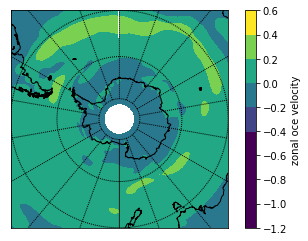

In [240]:
# load the variables and plot them
#filen=EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_UO'
filen=EXP+'_mpiom_last100year_ocean_uv'
variable='UKO'
cbar_label='zonal oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...


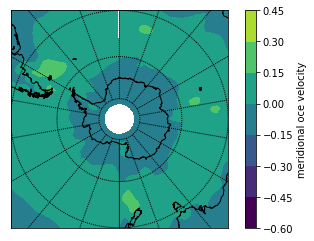

In [241]:
# load the variables and plot them
#filen=EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_VO'
filen=EXP+'_mpiom_last100year_ocean_uv'
variable='VKE'
cbar_label='meridional oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


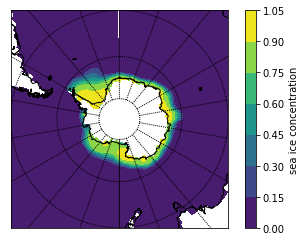

In [30]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_sisnconc'
variable='SICOMO'
cbar_label='sea ice concentration'
vmin, vmax=0.,1. #00.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


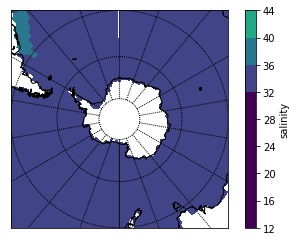

In [31]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_so'
variable='SAO'
cbar_label='salinity'
vmin, vmax=30.,50.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


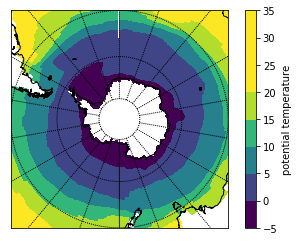

In [32]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_thetao'
variable='THO'
cbar_label='potential temperature'
vmin, vmax=-2.,20.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


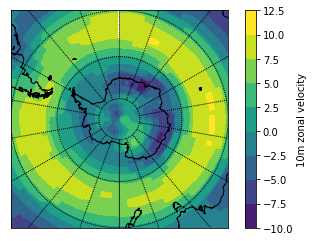

In [33]:
# load the variables and plot them
filen=EXP+'_echam5_last100year_catted_u10_v10' #'MM'
variable='u10'
cbar_label='10m zonal velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


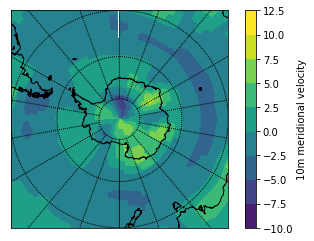

In [34]:
# load the variables and plot them
filen=EXP+'_echam5_last100year_catted_u10_v10'
variable='v10'
cbar_label='10m meridional velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


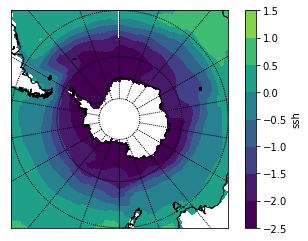

In [35]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO'
variable='ZO'
cbar_label='ssh'
vmin, vmax=-2.,2.

# load the data
SSH, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan and which month?
month=0
#level=0
SSH[SSH==-9.e+33]=np.nan

# plot the field
plot_field(SSH[month,:,:], cbar_label=cbar_label, vmin=vmin, vmax=vmax)

In [36]:
def compute_gradient(SSH, XX, YY):
    
    # add column to the left and right
    addcol=np.concatenate([np.expand_dims(SSH[:,:,-1],axis=2),SSH,np.expand_dims(SSH[:,:,0], axis=2)],axis=2)
    addcXX=np.concatenate([np.expand_dims(np.ones_like(XX[:,-1])*-1.,axis=1),XX,np.expand_dims(np.ones_like(XX[:,0])*360., axis=1)],axis=1)
    addcYY=np.concatenate([np.expand_dims(YY[:,-1],axis=1),YY,np.expand_dims(YY[:,0], axis=1)],axis=1)
    
    # SSH: (12, 180, 362) # already has columns added left and right
    lats=YY[:,0]
    ddx=np.zeros_like(SSH)
    ddy=np.zeros_like(SSH)
    
    # 1 ... 360 (0 and 361 were added)
    for column in np.arange(1,360+1):
        #print column
        ddx[:,:,column-1]=(addcol[:,:,column+1]-addcol[:,:,column-1])/(2.*111000.)
        
    for row in np.arange(1,180-1):
        #print row
        ddy[:,row,:]=(SSH[:,row+1,:]-SSH[:,row-1,:])/(2.*111000.*np.cos(YY[row,0]*rad))
        
    return ddx, ddy

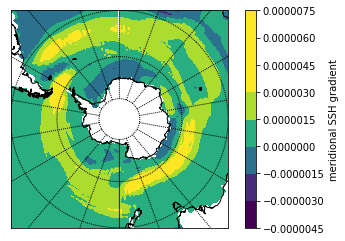

In [37]:
ddx, ddy = compute_gradient(SSH, XX, YY)

# which month and component?
cbar_label="meridional SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

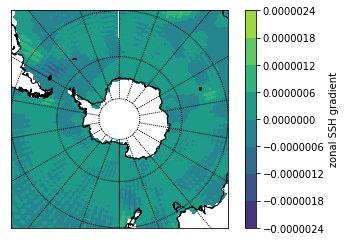

In [38]:
# get sea surface height slope

# which month and component?
cbar_label="zonal SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddx[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...


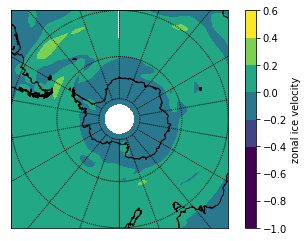

In [42]:
# load the variables and plot them; SICUO and SICVE
filen=EXP+'_mpiom_last100year_SIC_velocity'
variable='SICUO'
cbar_label='zonal ice velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...


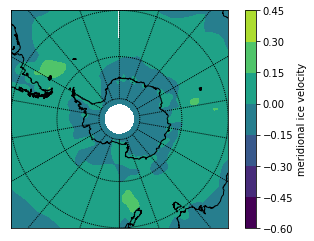

In [43]:
# load the variables and plot them; SICUO and SICVE
filen=EXP+'_mpiom_last100year_SIC_velocity'
variable='SICVE'
cbar_label='meridional ice velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

#### The iceberg drift (and decay) code

In [242]:
class Buoys:
    
    global rad, r_earth, g, omega, Co, Ca, Cdo_skin, Cda_skin, semiimplicit_coeff, rho_h2o, rho_icb, rho_air, smallestvol_icb, coriolis_slope_only, l_weeksmellor
    
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    g=9.81
    omega=7.2921e-5 # make latitude dependent later
    
    # if using iceberg dynamics:
    Co=0.85 # Lichey and Hellmer values
    Ca=1.4 # 0.4 # Lichey and Hellmer values
    Cdo_skin=5.0e-3 # Cd_oce_ice in FESOM is 5.0e-3
    Cda_skin=2.5e-3
    rho_icb=850.0 # Silva et al. 2006
    rho_h2o=1027.5
    rho_air=1.293
    smallestvol_icb=1000. #10000. # [m**3]
    semiimplicit_coeff=1.0 # fully implicit # 0.5 default
    coriolis_slope_only=False
    l_weeksmellor=True
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date, L, W, H):
        self.oldlon = lon_start*rad
        self.oldlat = lat_start*rad
        self.lon = lon_start*rad
        self.lat = lat_start*rad
        self.initlon = lon_start*rad
        self.initlat = lat_start*rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        self.L=L
        self.W=W
        self.H=H
        self.mass=L*W*H*rho_icb
        self.D = (rho_icb/rho_h2o)*H
        self.Ao = self.D * L
        self.Aa = (H - self.D) * L
        self.Ad = L * W
        self.massloss= 0. # m^3/second
       
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
    
    def getmonth_forcing(self):
        return np.int(self.date.month)-1
        
    def trajectory(self, new_u,new_v, delta_t):
        
        #print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg=self.lon/rad % 360
        lat_deg=np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        idx=getindices_beforestart(self.getdate(), self.startdates)
        lon_deg[idx] = np.nan
        lat_deg[idx] = np.nan
        self.lon[idx] = self.initlon[idx]
        self.lat[idx] = self.initlat[idx]
        self.old_u[idx]=0.
        self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg
    
    def momentum_balance(self, au_ib, av_ib, dt_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib):
        
        new_u_ib = self.old_u + au_ib * dt_ib
        new_v_ib = self.old_v + av_ib * dt_ib
        
        # for semiimplicit version, a matrix multiplication is to be performed
        # (semiimpl. coriolis term and implicit water drag)
 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )
        ocean_drag = (0.5 * Co * rho_h2o * self.Ao * abs_omib + rho_h2o * Cdo_skin * self.Ad * abs_omib_skin)/self.mass
   
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)
        
        # for tests with Coriolis and surface slope only
        if coriolis_slope_only==True:
            ocean_drag=np.zeros_like(abs_omib_skin)
        
        #SI_matrix(1,1) = 1. + dt_ib*ocean_drag
        #SI_matrix(1,2) = dt_ib*fcoriolis*semiimplicit_coeff
        #SI_matrix(2,1) =-SI_matrix(1,2)
        #SI_matrix(2,2) = SI_matrix(1,1)
        #SI_matrix = (1./( SI_matrix(2,2)**2 + SI_matrix(1,2)**2 )) * SI_matrix
        SI_matrix=np.array([[1. + dt_ib*ocean_drag, dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag)], \
                            [-dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag), 1. + dt_ib*ocean_drag]])
        SI_matrix = (1./( SI_matrix[1,1]**2 + SI_matrix[0,1]**2 )) * SI_matrix
        
        # new velocity after matrix multiplication
        # (2, 2, #bergs) x (2, #bergs)
        uv_temp=np.array([new_u_ib, new_v_ib])
        new_u_ib=sum(SI_matrix[0, 0:2, :] * uv_temp[0:2 , :])
        new_v_ib=sum(SI_matrix[1, 0:2, :] * uv_temp[0:2 , :])
        
        # rewrite like this..?
        #SI_matrix = np.einsum('ijn->nij', SI_matrix)
        #new_UV = np.dot(SI_matrix,[new_u_ib, new_v_ib])
        
        # might be melted already
        new_u_ib[self.mass==0.]=0.
        new_v_ib[self.mass==0.]=0.
        
        return new_u_ib, new_v_ib
    
    def compute_areas(self):
        
        # area of iceberg exposed to ocean, atm, (seaice), horizontal area
        self.Ao = self.D * self.L
        self.Aa = (self.H - self.D) * self.L
        # Ai = hi_ib * self.L
        self.Ad = self.L * self.W
    
    def acceleration(self, ua_ib, va_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib, detadx, detady):
        
        l_wave=True
        #l_wave=False
    
        # estimate wave height at the icebergs location (Bigg et al., 1997),
        # so wave_amplitude = 0.5 * wave_height = 0.5 * const. * abs(atm velo)**2
        vel_atm = np.sqrt(ua_ib**2 + va_ib**2)
        wave_amplitude = 0.5 * 0.02025 * vel_atm**2

        # assume that waves have same direction as the winds
        direction_u = ua_ib / vel_atm
        direction_v = va_ib / vel_atm

        # absolute values of relative velocities 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_amib = np.sqrt( (ua_ib - self.old_u)**2 + (va_ib - self.old_u)**2 )
        #abs_imib = sqrt( (ui_ib - u_ib)**2 + (vi_ib - v_ib)**2 )  
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )

        # u-components        
        ocean_drag_u     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * uo_ib)/self.mass #calculate part of it implicitly
        ocean_skin_u     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * uo_skin_ib)/self.mass # calculate part of it implicitly      
        air_drag_u       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (ua_ib - self.old_u))/self.mass
        air_skin_u       = (rho_air * Cda_skin * self.Ad * abs_amib * (ua_ib - self.old_u))/self.mass 
        #ice_drag_u       = (0.5 * Ci * rho_ice * Ai * abs_imib * (ui_ib - u_ib))/mass_ib

        if l_wave==True:
            wave_radiation_u = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_u /self.mass
        else:
            wave_radiation_u = 0.0

        # Fortran code used gradient smoothing for surface slope term
        # call mean_gradient(iceberg_elem, lon_rad, lat_rad, nablaeta)
        # no surface slope due to tides here

        surface_slope_u = -g * detadx #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafux_2D(:,iceberg_elem) ) # -g* nabla ssh


        # v-components     
        ocean_drag_v     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * vo_ib)/self.mass # calculate part of it implicitly
        ocean_skin_v     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * vo_skin_ib)/self.mass #calculate part of it implicitly
        air_drag_v       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (va_ib - self.old_v))/self.mass
        air_skin_v       = (rho_air * Cda_skin * self.Ad * abs_amib * (va_ib - self.old_v))/self.mass 
        #ice_drag_v       = (0.5 * Ci * rho_ice * Ai * abs_imib * (vi_ib - v_ib))/mass_ib

        if l_wave==True:
            wave_radiation_v = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_v /self.mass
        else:
            wave_radiation_v = 0.0

        # no additional surface slope due to tides

        surface_slope_v = -g * detady #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafuy_2D(:,iceberg_elem) )

        #USE (SEMI-)IMPLICIT SCHEME for coriolis term
        
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)

        au_ib = ocean_drag_u \
        + ocean_skin_u    \
        + air_drag_u       \
        + air_skin_u        \
        + wave_radiation_u   \
        + surface_slope_u    \
        + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 

        av_ib = ocean_drag_v \
        + ocean_skin_v    \
        + air_drag_v       \
        + air_skin_v        \
        + wave_radiation_v   \
        + surface_slope_v    \
        - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
        
        
        # TEST FOR CORIOLIS and SLOPE:
        if coriolis_slope_only==True:
            au_ib = surface_slope_u + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 
            av_ib = surface_slope_v - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
            
            
        # might be melted already    
        au_ib[self.mass==0.] = 0.   
        av_ib[self.mass==0.] = 0.
        
        return au_ib, av_ib
    
    def iceberg_meltrates(self, delta_t, sst_ib, conci_ib, uo_ib, vo_ib, ua_ib, va_ib, heuristic=False):
        
        if heuristic==True:
            
            # rate in m/s
            rate_per_month=1.7/100. # area (L*L) red. rate in m/month (Barbat et al., 2020)
            rate_per_second=np.sqrt(rate_per_month/(86400.*30.)) # L red. rate
            
            self.L = self.L - delta_t*rate_per_second
            self.W = self.W - delta_t*rate_per_second
            self.mass = self.H * self.L * self.W * rho_icb
            
        else:
            
            # calculates the empirical melt rates of the iceberg as in 
            # Martin: 'Parameterizing the fresh-water flux from land ice to ocean
            # with interactive icebergs in a coupled climate model'(2010)
            # and Hellmer et al. (1997).
            # (notice that the melt rates are in terms of m/s though, not in m/day)
            
            # bottom melt rate: M_b   [m/s]
            # lateral melt rate: M_v   [m/s]
            # wave erosion: M_e   [m/s]
            # lateral (basal) melt rate: M_bv [m/s]

            # NO (3eq formulation for basal melting yet;
            # use 3D information for T,S and velocities
            # instead of SSTs; M_v depends on 'thermal driving')
  
            # bottom melt (basal turbulent melting rate)
            M_b = np.zeros_like(self.L)
            M_b[self.L>0.] = 0.58 * np.sqrt( (self.old_u[self.L>0.] - uo_ib[self.L>0.])**2 + (self.old_u[self.L>0.] - vo_ib[self.L>0.])**2 )**0.8 * (sst_ib[self.L>0.] + 4.0) / self.L[self.L>0.]**0.2
            M_b = M_b/86400. # conversion of m/day to m/s

            #3-eq. formulation for bottom melting [m/s]    
            #v_ibmino  = sqrt( (u_ib - uo_keel_ib)**2 + (v_ib - vo_keel_ib)**2 )
            #call iceberg_heat_water_fluxes_3eq(ib, M_b, T_keel_ib,S_keel_ib,v_ibmino, depth_ib, tf)

            #3-eq. formulation for lateral 'basal' melting [m/s]
            #v_ibmino  = sqrt( (u_ib - uo_ib)**2 + (v_ib - vo_ib)**2 ) ! depth-average rel. velocity
            #call iceberg_heat_water_fluxes_3eq(ib, M_bv, T_ave_ib,S_ave_ib,v_ibmino, depth_ib/2.0, tf)
            M_bv=M_b

            #'thermal driving', defined as the elevation of ambient water 
            #temperature above freezing point' (Neshyba and Josberger, 1979).
            
            T_ave_ib=sst_ib # use sst for the moment
            tf=-2. # use constant value at the moment
            
            # thermal driving temp
            T_d = (T_ave_ib - tf) * np.ones_like(self.L)
            T_d[T_d < 0.]=0. 
            
            #!write(*,*) 'thermal driving:',T_d,'; Tf:',tf,'T_ave:',T_ave_ib

            #lateral melt (buoyant convection)
            #M_v = 0.00762 * sst_ib + 0.00129 * sst_ib**2
            #M_v = M_v/86400.
            #M_v is a function of the 'thermal driving', NOT just sst! Cf. Neshyba and Josberger (1979)
            M_v = 0.00762 * T_d + 0.00129 * T_d**2
            M_v = M_v/86400.

            #wave erosion
            absamino = np.sqrt( (ua_ib - uo_ib)**2 + (va_ib - vo_ib)**2 )
            sea_state = 3./2.*np.sqrt(absamino) + 1./10.*absamino
            damping = 0.5 * (1.0 + np.cos(conci_ib**3 * np.pi))
            M_e = 1./6. * sea_state * T_d * damping # replaced (sst_ib + 2.0) by Td
            M_e = M_e/86400.
            
            M_b[np.isnan(M_b)]=0.
            M_v[np.isnan(M_v)]=0.
            M_e[np.isnan(M_e)]=0.
            M_bv[np.isnan(M_bv)]=0.
            
        return M_b, M_v, M_e, M_bv
    
    def weeksmellor(self, volume_after):
    
        # check stability
        # l_rollover = (length_ib < sqrt(0.92 * height_ib**2  +  58.32 * height_ib)) # old FORTRAN
        alpha = rho_icb/rho_h2o
        epsilon_crit = np.sqrt(6*alpha*(1-alpha)) # Wagner et al. 2017 correction, , http://dx.doi.org/10.1016/j.ocemod.2017.07.003
        
        epsilon=np.ones_like(self.H)*(epsilon_crit+1.) # set to value larger than critical value
        epsilon[self.H>0]= self.W[self.H>0]/self.H[self.H>0]
        l_rollover = epsilon < epsilon_crit
    
        # if l_rollover == True:
        self.H[l_rollover]= self.L[l_rollover] # new height is the previous length
        self.D = self.H * alpha
            
        # calculate L and W so that volume is still correct
        self.L[l_rollover] = np.sqrt(volume_after[l_rollover]/self.H[l_rollover])
        self.W = self.L
            

    def iceberg_newdimensions(self, delta_t, M_b,M_v,M_e,M_bv):
        
        # changes in this timestep:
        dh_b = M_b*delta_t # change of height..
        dh_v = M_v*delta_t # ..and length due to melting..
        dh_e = M_e*delta_t # ..and due to wave erosion [m].
        dh_bv = M_bv*delta_t # M_bv*dt # change of length due to 'basal meltrate'
        
        # CALCULATION OF WORKING SURFACES AS IN BIGG (1997) & SILVA (2010)
        # basal volume loss
        bvl = dh_b*self.L**2
        
        # lateral volume loss
        lvl_e = dh_e*self.L*self.H + dh_e*self.W*self.H # erosion just at 2 sides
        lvl_b = dh_bv*2.*self.L*self.D + dh_bv*2*self.W*self.D # at all 4 sides
        lvl_v = dh_v*2.*self.L*self.D + dh_v*2*self.W*self.D # at all 4 sides
        # total volume loss
        tvl = bvl + lvl_b + lvl_v + lvl_e # [m^3] per timestep
        volume_before=self.H*self.L*self.W
    
        #if((tvl*rho_icb >= self.mass) or (self.mass <= 1000.*rho_icb)):
        
        # if more ice is to be melted than there is, or when the mass is smaller than allowed
        whereidx=np.logical_or(tvl*rho_icb >= self.mass, self.mass <= smallestvol_icb*rho_icb)
        tvl[whereidx] = self.mass[whereidx] / rho_icb
        self.mass[whereidx] = 0.
        self.L[whereidx] = 0.
        self.W[whereidx] = 0.
        self.H[whereidx] = 0.
        self.D[whereidx] = 0.        
            
        # define last tvl to be erosional loss
        bvl[whereidx] = 0.0
        lvl_b[whereidx] = 0.0
        lvl_v[whereidx] = 0.0
        lvl_e[whereidx] = tvl[whereidx]

        #volume_after=volume_before-tvl
            
        # calculating the new iceberg dimensions
        # print('max dh_b', np.max(dh_b))
        self.H = self.H - dh_b
        self.H[self.H< 0.]=0. # in case basal melt is strong
        self.D = self.H * rho_icb/rho_h2o
    
        # calculate L so that new volume is correct
        volume_after=self.H*self.L*self.W
        self.L[self.H >0.] = np.sqrt(volume_after[self.H >0.]/self.H[self.H >0.])
        self.W = self.L # quadratic at the moment
    
        #distribute dh_e equally between length and width
        #as in code of michael schodlok, but not dh_v? 
        #length_ib= length_ib - dh_v -dh_e/2.
        #width_ib = width_ib  - dh_v -dh_e/2.
    
        #volume_after=height_ib*length_ib*width_ib

        # iceberg smaller than critical value after melting?
        #if (volume_after <= smallestvol_icb):
        whereidx=(volume_after <= smallestvol_icb)
            
        volume_after[whereidx]=0.0
        self.D[whereidx] = 0.0
        self.H[whereidx]= 0.0
        self.L[whereidx]= 0.0
        self.W[whereidx] = 0.0
        tvl[whereidx] = volume_before[whereidx]
        # define last tvl to be erosional loss
        #bvl = 0.0
        #lvl_b = 0.0
        #lvl_v = 0.0
        #lvl_e = tvl
        
        self.mass = self.mass - tvl*rho_icb
        self.volloss = tvl / delta_t
    
        # stability criterion: icebergs are allowed to roll over
        #  call weeksmellor(	depth_ib, height_ib, length_ib, width_ib, rho_h2o, rho_icb, volume_after)  
        if l_weeksmellor: 
            self.weeksmellor(volume_after)

        #OUTPUT of averaged meltrates in [m^3 (ice) per day]
        #bvl_mean(ib)=bvl_mean(ib)+(bvl/real(icb_outfreq))
        #lvlv_mean(ib)=lvlv_mean(ib)+(lvl_v/real(icb_outfreq))
        #lvle_mean(ib)=lvle_mean(ib)+(lvl_e/real(icb_outfreq))
        #lvlb_mean(ib)=lvlb_mean(ib)+(lvl_b/real(icb_outfreq))

In [243]:
# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(start_dates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices

In [244]:
# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(XX,YY, Ufield,Vfield, objects, returnidx=False):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    
    # don't change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    #lon_adjust=objects.lon/rad
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((objects.lon/rad,objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx=spatial.KDTree(A).query(tuples)[1]
    
    #if np.any(idx==np.shape(XX[:,:].flatten())[0]):
    #    print(A.min(), A.max(), tuples.min(), tuples.max(), idx)
    #    return np.zeros_like(idx), np.zeros_like(idx)
    #else:
    if returnidx==True:
        return Ufield[idx], Vfield[idx], idx
    else:
        return Ufield[idx], Vfield[idx]

In [245]:
def find_idx_atbuoy_pos(XX,YY, poslon, poslat):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # don't change to -180..180 as assumed in OSISAF data; poslon is 0..360 and
    # the remapped data as well
    #lon_adjust=poslon
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((poslon,poslat)) 
    
    # fast KDTree nearest neighbor method
    return spatial.KDTree(A).query(tuples)[1]

### Let's compute the trajectories

In [246]:
ls ../Wesche-Dierking_2015.csv

../Wesche-Dierking_2015.csv


In [247]:
# Latitude / Longitude / Area [km**2] / Perimeter [m] / width [m] / length [m] / Orientation [deg]

In [248]:
DATA = np.loadtxt('../Wesche-Dierking_2015.csv',delimiter=';',skiprows=19,comments="*/")
DATA.shape, DATA[:,1].min(), DATA[:,1].max()

((6912, 7), -165.9942, 169.4438)

In [249]:
# use Weddell Sea icebergs only
weddell_idx=np.logical_and(DATA[:,1]>=-63., DATA[:,1]<=-50.)
poslat,poslon,areas=DATA[weddell_idx,0],DATA[weddell_idx,1],DATA[weddell_idx,2]
# all
#poslat,poslon,areas=DATA[:,0],DATA[:,1],DATA[:,2] 

lengths=np.sqrt(areas)*1000. # to meters
widths=lengths
heights=np.ones_like(poslon)*250. #0. # 250m
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00'] * num_buoys
num_buoys

111

In [250]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
#poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
#poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
#lengths=np.ones_like(poslon)*2000. #5000. # 1000m
#widths=np.ones_like(poslon)*2000. #5000. # 1000m
#heights=np.ones_like(poslon)*250. #0. # 250m

# move positions 5 degrees eastwards
# poslon=poslon+5. # works
poslon=poslon+10. # move 10 for consistency with LGM run

# config
initialdate='1900-01-01 12:00:00'
num_times=10*12*3 #10*12*3 #120   # number of iterations: integrate for x ...
delta_t=86400*10 #*30 #... days [time step in seconds]
#substeps=30
num_buoys=poslon.shape[0]
#start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
melt = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)
melt_df = pd.DataFrame(data=melt, index=dates)
# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate] = 0. # no melt initially
lons_df

(111,)


,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.5122,315.5936,308.0017,314.2368,307.8533,313.3589,310.7969,307.299,309.3724,312.3709,...,309.3928,311.6255,309.3456,309.7535,310.6472,311.063,309.8118,309.6877,312.4398,310.9017


In [251]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [252]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[38:40])

# get ssh slope
SSH = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=0. #-3.e-6
ddx[SSHnan==-9.e+33]=-3.e-6 # 0.

# get winds
Uafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent

# get sea ice velocity
Uicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICUO', returncoords=True, threeD=False)
Vicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICVE', returncoords=True, threeD=False)
Uicefield[Uicefield==-9.e+33]=np.nan
Vicefield[Vicefield==-9.e+33]=np.nan
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #month=i % 12
    month=objects.getmonth_forcing()
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate sea ice velocity fields at buoy position
    Uicefield_flatten, Vicefield_flatten=Uicefield[month,:,:].flatten(),Vicefield[month,:,:].flatten()
    ui_ib, vi_ib=Uicefield_flatten[idx], Vicefield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    #sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # lock icebergs into the sea ice
    Asill=86. # Schodlok et al . [2006] 
    U[conci_ib>Asill],V[conci_ib>Asill]=ui_ib[conci_ib>Asill],vi_ib[conci_ib>Asill]
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    objects.compute_areas() # NEW
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    # append the iceberg volume loss
    melt_df.loc[objects.getdate()] = objects.volloss
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate][idx] = np.nan
lons_df

loading ./PI_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
[17.  6.]
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
This is loop #0


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30
This is loop #31
This is loop #32
This is loop #33
This is loop #34


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launc

This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39
This is loop #40
This is loop #41
This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This is loop #60
This is loop #61
This is loop #62
This is loop #63
This is loop #64
This is loop #65
This is loop #66
This is loop #67
This is loop #68
This is loop #69
This is loop #70
This is loop #71
This is loop #72
This is loop #73
This is loop #74
This is loop #75
This is loop #76
This is loop #77
This is loop #78
This is loop #79
This is loop #80
This is loop #81
This is loop #82
This is loop #83
This is loop #84
This is loop #85
This is loop #86
This is loop #87
This is loop #88
This is loop #89
This is loop #90
This is loop #91
This is loop #92
This is loop #

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.512200,315.593600,308.001700,314.236800,307.853300,313.358900,310.796900,307.299000,309.372400,312.370900,...,309.392800,311.625500,309.345600,309.753500,310.647200,311.063000,309.811800,309.687700,312.439800,310.901700
1900-01-11 12:00:00,310.608643,315.644332,308.029035,314.289887,307.880748,313.494594,310.894808,307.285700,309.448825,312.520673,...,309.219504,311.791678,309.171815,309.820821,310.693479,311.180347,309.883179,309.501012,312.636287,311.020351
1900-01-21 12:00:00,310.799942,315.745910,308.082736,314.396763,307.934696,313.764079,311.089080,307.259413,309.598812,312.806093,...,308.874917,312.122858,308.826149,309.954755,310.785642,311.414672,310.025542,309.382907,313.035280,311.257326
1900-01-31 12:00:00,310.989614,315.847523,308.135444,314.504208,307.987673,314.054197,311.281770,307.233401,309.713456,313.078536,...,308.534263,312.452918,308.484229,310.087986,310.877341,311.648551,310.167500,309.518029,313.440071,311.493889
1900-02-10 12:00:00,311.179181,315.948969,308.188096,314.629632,308.040596,314.366171,311.474356,307.207315,309.796794,313.352062,...,308.197446,312.783070,308.170516,310.221211,310.968899,311.934424,310.309429,309.656611,313.844495,311.730281
1900-02-20 12:00:00,311.377416,316.037636,308.252001,314.766715,308.104683,314.682321,311.675502,307.195027,309.893459,313.632984,...,307.903983,313.105158,307.909007,310.372247,311.076142,312.274829,310.468489,309.814770,314.202478,312.021044
1900-03-02 12:00:00,311.584130,316.114573,308.327112,314.897449,308.179885,315.079219,311.935207,307.196682,310.002101,313.941321,...,307.652999,313.418996,307.667147,310.540866,311.198953,312.617734,310.644565,309.989857,314.513766,312.366261
1900-03-12 12:00:00,311.854178,316.239087,308.404669,315.032012,308.257563,315.560580,312.253765,307.198473,310.120507,314.281812,...,307.391834,313.746446,307.390959,310.486450,311.327746,312.962485,310.594148,309.939466,314.992764,312.726252
1900-03-22 12:00:00,312.182354,316.457959,308.485245,315.171341,308.338274,316.039704,312.581317,307.200949,310.249111,314.634348,...,307.141288,314.108171,307.106240,310.210743,311.462494,313.308816,310.319733,309.666038,315.638356,313.088032
1900-04-01 12:00:00,312.505187,316.722426,308.566277,315.311519,308.419424,316.509130,312.899112,307.204082,310.377941,315.066133,...,306.914293,314.489985,306.846890,309.938720,311.596960,313.654751,310.048988,309.397001,316.302945,313.436582


In [253]:
melt_df

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1900-01-11 12:00:00,0.218938,0.400037,0.288438,0.517983,0.292402,0.247065,0.225182,0.279329,0.299696,0.282779,...,0.742192,1.345454,1.354264,0.894709,1.328247,2.925425,2.697918,5.814176,4.624007,6.562953
1900-01-21 12:00:00,0.217399,0.400188,0.287796,0.518186,0.291758,0.245152,0.223659,0.279011,0.296904,0.251567,...,0.742019,1.338829,1.353937,0.892256,1.327413,2.920348,2.693812,2.915456,5.303293,6.552660
1900-01-31 12:00:00,0.217300,0.400045,0.287707,0.518084,0.291669,0.141106,0.223559,0.278971,0.172750,0.252599,...,0.741846,1.338445,1.353609,0.892180,1.327224,2.920260,2.693702,3.646794,5.301949,6.552855
1900-02-10 12:00:00,0.217176,0.399898,0.287612,0.454782,0.291574,0.140439,0.223436,0.278930,0.173238,0.252427,...,0.741673,1.337973,1.030304,0.892075,1.327037,3.733679,2.693567,2.955539,5.301794,6.553218
1900-02-20 12:00:00,0.350966,1.789685,0.134632,0.192068,0.136593,0.297000,0.360460,0.304041,0.087391,0.425019,...,0.722308,1.811680,0.679168,0.974685,0.906850,4.140119,2.923575,3.207834,5.138232,9.295990
1900-03-02 12:00:00,0.350620,1.790460,0.134535,0.192039,0.136493,0.342544,0.325595,0.303883,0.087299,0.306087,...,0.722143,1.810918,0.981360,0.973772,0.906603,4.138823,2.922253,3.206463,5.134724,9.296275
1900-03-12 12:00:00,0.238319,0.164573,0.268204,0.690829,0.271888,0.504222,0.240746,0.188452,0.084366,0.272420,...,0.743063,0.720396,1.407724,1.890711,1.323584,2.315707,5.173471,5.105623,6.435844,8.176086
1900-03-22 12:00:00,0.233844,0.207619,0.268131,0.689337,0.271814,0.341350,0.240624,0.188054,0.084422,0.272346,...,0.943159,1.304187,0.774028,1.669488,1.323298,2.313846,5.172566,5.104917,6.419526,5.826666
1900-04-01 12:00:00,0.233765,0.207238,0.268039,0.689342,0.271722,0.342400,0.114384,0.187993,0.084406,0.524467,...,0.942879,1.302852,0.868001,1.669069,1.323113,2.314245,4.676910,5.104211,6.665019,5.821434


- SSTs and Iceberg data are taken as the zonal average between 0 and 50oE for each 1x1 degree grid

- The ‘Agulhas Plateau Composite’ (APcomp) consists of MD02-258816 (41o19.90’S, 25o49.70’E, 2907 m water depth) and
International Ocean Discovery Program (IODP) Site U147517 67 (41o25.60’S, 25o15.60’E, 2669 m
68 water depth).

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


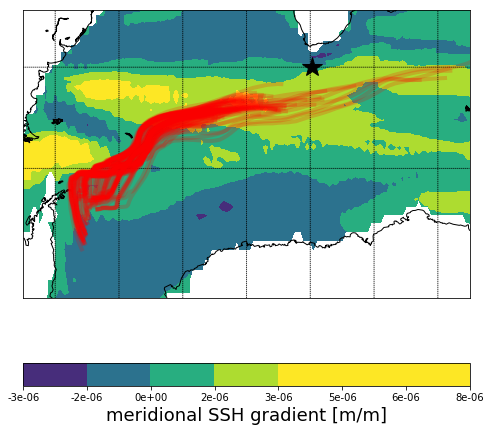

In [254]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
projectiontype='other'
#m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
projectiontype='merc'
m = Basemap(llcrnrlon=-70.,llcrnrlat=-75.,urcrnrlon=70.,urcrnrlat=-25.,\
            resolution='l',projection='merc',\
            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax)

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')


# shift XX for Mercator projection
lons_atm=np.copy(XX[0,:])
XX_shift=np.copy(XX)
XX_shift[XX>180.]=XX_shift[XX>180.]-360.

reorderlons = False
if projectiontype=='merc':
    reorderlons=True 

# -------------------------------------------------------------------- #
if reorderlons==True:
    # lons_atm: 0..360, lats_atm: 90..-90   
    lons_atm[lons_atm>=180]=lons_atm[lons_atm>=180]-360. # 0..180 -180..0
    # apply function lambda(x)=lons_atm[x] to [0..191] before sorting
    I=sorted(range(len(lons_atm)),key=lambda x:lons_atm[x])
    # reorder the longitudes and data
    XX_shift=XX_shift[:,I] 
    # lons_atm: -180..180
    
    lon_map,lat_map=m(XX_shift[:,1:],YY[:,1:])
    
else:
    lon_map,lat_map=m(XX[:,1:],YY[:,1:])

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
#month=0
#plotfield=np.squeeze(ddy[month,:,:])
plotfield=np.squeeze(np.nanmean(ddy[0:12,:,:], axis=0))

# plot the field
if reorderlons==True:
    im=m.contourf(lon_map,lat_map,plotfield[:,I[1:]],vmin=vmin, vmax=vmax)
else:
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax.plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    if reorderlons:
        a[a>=180]=a[a>=180]-360. # 0..180 -180..0
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax.plot(lon_traj, lat_traj, 'r', lw=4, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax)
cbar.set_label(cbar_label, fontsize=18)

plt.show()

In [255]:
objects.mass

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice


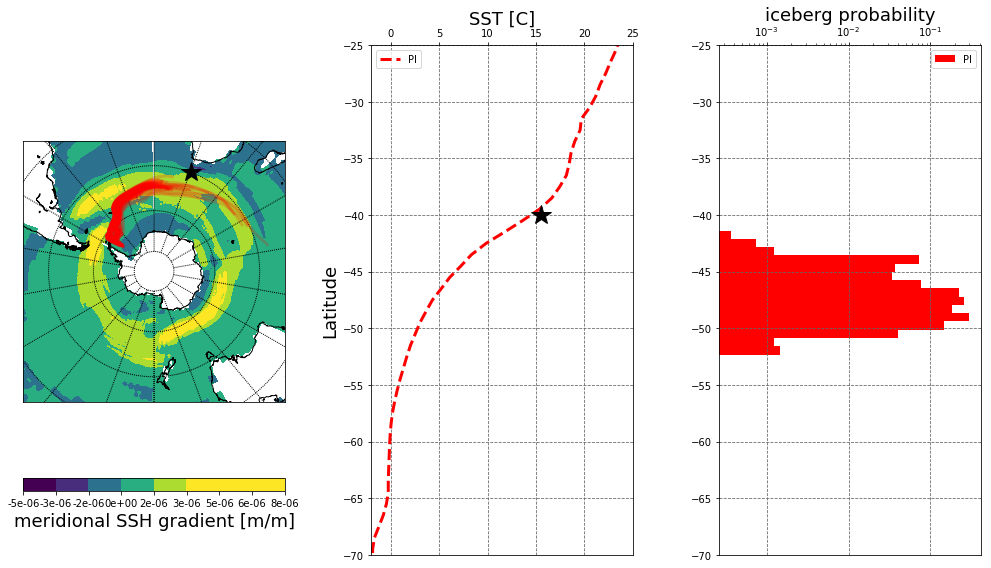

In [263]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(14,8))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
#m = Basemap(llcrnrlon=-80.,llcrnrlat=-75.,urcrnrlon=50.,urcrnrlat=-25.,\
#            resolution='l',projection='merc',\
#            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(XX[:,:],YY[:,:])

# plot SSH as background
#cbar_label='mean sea surface height [m]'
#vmin=-2.
#vmax=2.
#SSH[SSH==-9.e+33]=np.nan
#plotfield=np.mean(SSH,axis=0)

# set to nan; which month and level?
#cbar_label="surface temperature"
#month=0
#level=39
#vmin=-2.
#vmax=20.
#plotfield=potT[month,level,:,:]

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'r', lw=3, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
cbar.set_label(cbar_label, fontsize=18)


#############################
# SST as function of latitude
level=39 #surface
temp=np.nanmean(potT[:,level,:,:], axis=0)
agulhas=np.reshape(temp[np.logical_and(XX<50.,YY<-20.)], (70,50))
agulhas_zonalmean=np.nanmean(agulhas, axis=1)

x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
y=agulhas_zonalmean # SST
ax[1].plot(y,x,color='red', linestyle='dashed', label='PI', lw=3)
#ax=plt.gca()
ax[1].xaxis.tick_top()
ax[1].set_xlabel(r'SST [C]', fontsize=18)    
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Latitude', fontsize=18)  

# plot APcomp
x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
y_APcomp=15.5
ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
ax[1].set_ylim((-70,-25))
ax[1].set_xlim((-2,25))
ax[1].legend()

#ax[1].grid()
plt.rc('grid', linestyle="--", color='0.4')
ax[1].grid(True)

#plt.rc('grid', linestyle="--", color='0.4')

#####################
# PDF of iceberg latitudes in range 0-50E
agulhas_positions=np.array(lats_df[np.logical_and(lons_df<50., lons_df>0.)]).flatten()
plt.rc('grid', linestyle="--", color='0.4')
ax[2].grid(True)
ax[2].hist(np.ma.masked_array(agulhas_positions, mask=np.isnan(agulhas_positions)),bins=15, normed=True, color='red', orientation=u'horizontal', log=True, label='PI')
ax[2].set_ylim((-70,-25))
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlabel('iceberg probability', fontsize=18)  
plt.legend()

plt.tight_layout()
plt.show()

In [264]:
np.sum(objects.L==0.)

111

In [265]:
# save before LGM is computed
lons_df_PI=lons_df
lats_df_PI=lats_df
melt_df_PI=melt_df
agulhas_zonalmean_PI=agulhas_zonalmean
agulhas_positions_PI=agulhas_positions

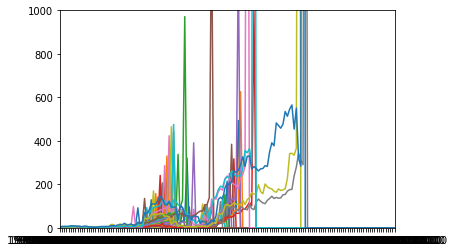

In [268]:
plt.plot(melt_df)
plt.axis([0, 150, 0, 0.1e4])
plt.show()

In [306]:
cd ../LGM_update/

/Users/trackow/Documents/science-icebergs-lgm/LGM_update


In [307]:
EXP='LGM'

In [308]:
ls

LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc
LGM_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc
LGM_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc
LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc


In [309]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/LGM_update'

In [310]:
# use Weddell Sea icebergs only
weddell_idx=np.logical_and(DATA[:,1]>=-63., DATA[:,1]<=-50.)
poslat,poslon,areas=DATA[weddell_idx,0],DATA[weddell_idx,1],DATA[weddell_idx,2]
# all
#poslat,poslon,areas=DATA[:,0],DATA[:,1],DATA[:,2] 

lengths=np.sqrt(areas)*1000. # to meters
widths=lengths
heights=np.ones_like(poslon)*250. #0. # 250m
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00'] * num_buoys

# move positions 10 degrees eastwards
poslon=poslon+10.
#poslat=poslat+10.

num_buoys

111

In [311]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
#poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
#poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
#lengths=np.ones_like(poslon)*2000. #5000. # 1000m
#widths=np.ones_like(poslon)*2000. #5000. # 1000m
#heights=np.ones_like(poslon)*250. #0. # 250m

# config
initialdate='1900-01-01 12:00:00'
num_times=10*12*3 #10*12*3 #120   # number of iterations: integrate for x ...
delta_t=86400*10 #*30 #... days [time step in seconds]
#substeps=30
num_buoys=poslon.shape[0]
#start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

(111,)


,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.5122,315.5936,308.0017,314.2368,307.8533,313.3589,310.7969,307.299,309.3724,312.3709,...,309.3928,311.6255,309.3456,309.7535,310.6472,311.063,309.8118,309.6877,312.4398,310.9017


In [312]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [313]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[38:40])

# get ssh slope
SSH = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=0. #-3.e-6
ddx[SSHnan==-9.e+33]=-3.e-6 # 0.

# get winds
Uafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent

# get sea ice velocity
Uicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICUO', returncoords=True, threeD=False)
Vicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICVE', returncoords=True, threeD=False)
Uicefield[Uicefield==-9.e+33]=np.nan
Vicefield[Vicefield==-9.e+33]=np.nan
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #month=i % 12
    month=objects.getmonth_forcing()
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate sea ice velocity fields at buoy position
    Uicefield_flatten, Vicefield_flatten=Uicefield[month,:,:].flatten(),Vicefield[month,:,:].flatten()
    ui_ib, vi_ib=Uicefield_flatten[idx], Vicefield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    #sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # lock icebergs into the sea ice
    Asill=86. # Schodlok et al . [2006] 
    U[conci_ib>Asill],V[conci_ib>Asill]=ui_ib[conci_ib>Asill],vi_ib[conci_ib>Asill]
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    objects.compute_areas() # NEW
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    # append the iceberg volume loss
    melt_df.loc[objects.getdate()] = objects.volloss
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate][idx] = np.nan
lons_df

loading ./LGM_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
[17.  6.]
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
This is loop #0


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30
This is loop #31
This is loop #32
This is loop #33
This is loop #34
This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launc

This is loop #40
This is loop #41
This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This is loop #60
This is loop #61
This is loop #62
This is loop #63
This is loop #64
This is loop #65
This is loop #66
This is loop #67
This is loop #68
This is loop #69
This is loop #70
This is loop #71
This is loop #72
This is loop #73
This is loop #74
This is loop #75
This is loop #76
This is loop #77
This is loop #78
This is loop #79
This is loop #80
This is loop #81
This is loop #82
This is loop #83
This is loop #84
This is loop #85
This is loop #86
This is loop #87
This is loop #88
This is loop #89
This is loop #90
This is loop #91
This is loop #92
This is loop #93
This is loop #94
This is loop #95
This is loop #96
This is loop #97
This is loop #

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.512200,315.593600,308.001700,314.236800,307.853300,313.358900,310.796900,307.299000,309.372400,312.370900,...,309.392800,311.625500,309.345600,309.753500,310.647200,311.063000,309.811800,309.687700,312.439800,310.901700
1900-01-11 12:00:00,310.504397,315.623659,307.985322,314.255820,307.836941,313.350741,310.789005,307.324286,309.380696,312.355115,...,309.405212,311.609841,309.327179,309.761246,310.633932,311.055099,309.819541,309.703498,312.421413,310.893789
1900-01-21 12:00:00,310.488891,315.684677,307.952738,314.294061,307.804394,313.334533,310.773318,307.374679,309.397186,312.323762,...,309.429875,311.578738,309.290587,309.776633,310.607577,311.039402,309.834916,309.726894,312.384905,310.878072
1900-01-31 12:00:00,310.463316,315.746574,307.985772,314.332486,307.836947,313.311188,310.757833,307.424720,309.413476,312.292834,...,309.454224,311.548051,309.254484,309.791811,310.586590,311.023907,309.850083,309.742097,312.351099,310.862558
1900-02-10 12:00:00,310.411701,315.808427,308.060909,314.370872,307.911410,313.278598,310.749461,307.443684,309.401946,312.274719,...,309.478268,311.545812,309.218855,309.806787,310.570826,311.030003,309.865049,309.757098,312.319911,310.869763
1900-02-20 12:00:00,310.346270,315.903735,308.144694,314.438071,307.994630,313.261294,310.755187,307.426128,309.351608,312.243025,...,309.520742,311.529985,309.220364,309.804831,310.548394,311.081142,309.863094,309.755139,312.281746,310.924014
1900-03-02 12:00:00,310.283439,316.032405,308.261988,314.534543,308.111083,313.261564,310.768127,307.402883,309.290415,312.185731,...,309.576967,311.473105,309.257992,309.786405,310.565876,311.156065,309.844681,309.736684,312.230412,311.002938
1900-03-12 12:00:00,310.228281,316.172437,308.391503,314.614973,308.239680,313.253117,310.740601,307.381371,309.301996,312.129974,...,309.627095,311.420414,309.285790,309.776090,310.563430,311.159468,309.834372,309.726352,312.174246,311.008299
1900-03-22 12:00:00,310.156055,316.323703,308.531504,314.678354,308.378738,313.235909,310.673212,307.361592,309.362999,312.093643,...,309.672332,311.374853,309.326342,309.777434,310.495830,311.092059,309.835716,309.727699,312.122104,310.940811
1900-04-01 12:00:00,310.060236,316.474672,308.621733,314.728436,308.518246,313.217066,310.634858,307.451719,309.402497,312.073905,...,309.691798,311.332703,309.387930,309.782465,310.401484,311.031301,309.805819,309.732737,312.078597,310.879463


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


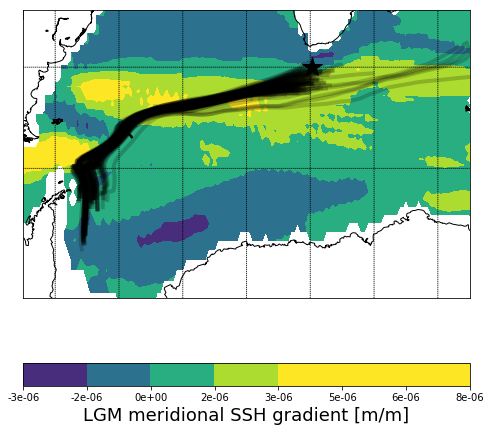

In [314]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
projectiontype='other'
#m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
projectiontype='merc'
m = Basemap(llcrnrlon=-70.,llcrnrlat=-75.,urcrnrlon=70.,urcrnrlat=-25.,\
            resolution='l',projection='merc',\
            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax)

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')


# shift XX for Mercator projection
lons_atm=np.copy(XX[0,:])
XX_shift=np.copy(XX)
XX_shift[XX>180.]=XX_shift[XX>180.]-360.

reorderlons = False
if projectiontype=='merc':
    reorderlons=True 

# -------------------------------------------------------------------- #
if reorderlons==True:
    # lons_atm: 0..360, lats_atm: 90..-90   
    lons_atm[lons_atm>=180]=lons_atm[lons_atm>=180]-360. # 0..180 -180..0
    # apply function lambda(x)=lons_atm[x] to [0..191] before sorting
    I=sorted(range(len(lons_atm)),key=lambda x:lons_atm[x])
    # reorder the longitudes and data
    XX_shift=XX_shift[:,I] 
    # lons_atm: -180..180
    
    lon_map,lat_map=m(XX_shift[:,1:],YY[:,1:])
    
else:
    lon_map,lat_map=m(XX[:,1:],YY[:,1:])

# plot meridional SSH gradient as background
cbar_label=EXP+" meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
#month=0
#plotfield=np.squeeze(ddy[month,:,:])
plotfield=np.squeeze(np.nanmean(ddy[0:12,:,:], axis=0))

# plot the field
if reorderlons==True:
    im=m.contourf(lon_map,lat_map,plotfield[:,I[1:]],vmin=vmin, vmax=vmax)
else:
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax.plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    if reorderlons:
        a[a>=180]=a[a>=180]-360. # 0..180 -180..0
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax.plot(lon_traj, lat_traj, 'k', lw=4, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax)
cbar.set_label(cbar_label, fontsize=18)

plt.show()

In [315]:
objects.volloss

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice


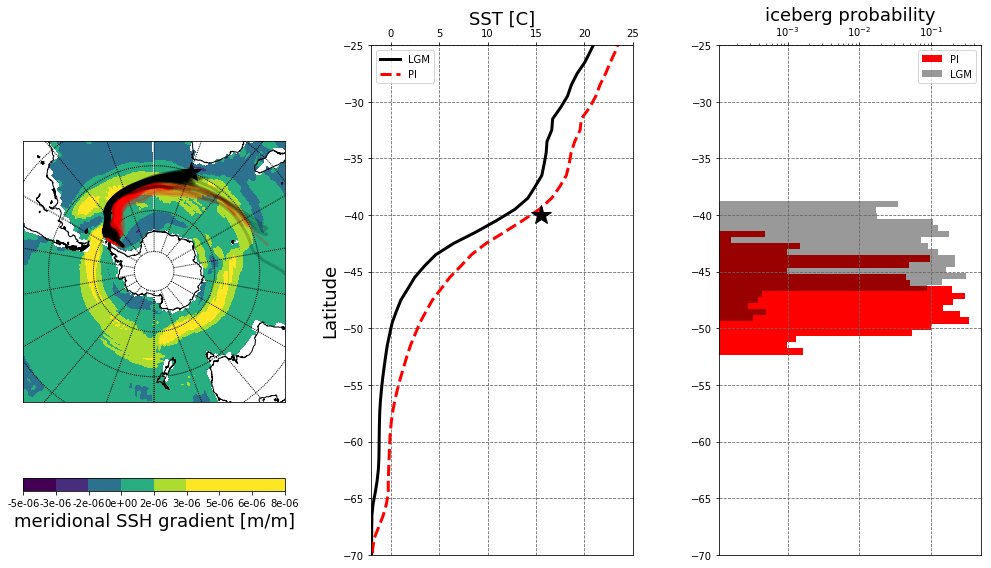

In [316]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(14,8))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
#m = Basemap(llcrnrlon=-80.,llcrnrlat=-75.,urcrnrlon=50.,urcrnrlat=-25.,\
#            resolution='l',projection='merc',\
#            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])
#shiftlons=False

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

#if shiftlons:
#    XX[XX>180.]=XX[XX>180.]-360.
lon_map,lat_map=m(XX[:,:],YY[:,:])

# plot SSH as background
#cbar_label='mean sea surface height [m]'
#vmin=-2.
#vmax=2.
#SSH[SSH==-9.e+33]=np.nan
#plotfield=np.mean(SSH,axis=0)

# set to nan; which month and level?
#cbar_label="surface temperature"
#month=0
#level=39
#vmin=-2.
#vmax=20.
#plotfield=potT[month,level,:,:]

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)

# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df_PI[buoynum][:].values, mask=np.isnan(lons_df_PI[buoynum][:].values))
    b = np.ma.array(lats_df_PI[buoynum][:].values, mask=np.isnan(lats_df_PI[buoynum][:].values))
    
    #if shiftlons:
    #    a[a>180.]=a[a>180.]-360.
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'r', lw=3, alpha=0.2)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    #if shiftlons:
    #    a[a>180.]=a[a>180.]-360.
        
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'k', lw=3, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
cbar.set_label(cbar_label, fontsize=18)


#############################
# SST as function of latitude
level=39 #surface
temp=np.nanmean(potT[:,level,:,:], axis=0)
agulhas=np.reshape(temp[np.logical_and(np.logical_and(XX<50.,XX>=0.),YY<-20.)], (70,50))
agulhas_zonalmean=np.nanmean(agulhas, axis=1)

x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
y=agulhas_zonalmean # SST
ax[1].plot(y,x,color='k', linestyle='-', label=EXP, lw=3)
#ax=plt.gca()
ax[1].xaxis.tick_top()
ax[1].set_xlabel(r'SST [C]', fontsize=18)    
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Latitude', fontsize=18)  

# plot PI value
ax[1].plot(agulhas_zonalmean_PI,x,color='r', linestyle='--', label='PI', lw=3)

# plot APcomp
x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
y_APcomp=15.5
ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
ax[1].set_ylim((-70,-25))
ax[1].set_xlim((-2,25))
ax[1].legend()

#ax[1].grid()
plt.rc('grid', linestyle="--", color='0.4')
ax[1].grid(True)

#plt.rc('grid', linestyle="--", color='0.4')

#####################
# PDF of iceberg latitudes in range 0-50E
normed=True
agulhas_positions=np.array(lats_df[np.logical_and(lons_df<50.,lons_df>=0.)]).flatten()
plt.rc('grid', linestyle="--", color='0.4')
ax[2].grid(True)
ax[2].hist(np.ma.masked_array(agulhas_positions_PI, mask=np.isnan(agulhas_positions_PI)),bins=20, normed=normed, color='red', orientation=u'horizontal', log=True, label='PI')
ax[2].hist(np.ma.masked_array(agulhas_positions, mask=np.isnan(agulhas_positions)),bins=20, normed=normed, color='k', orientation=u'horizontal', log=True, label=EXP, alpha=0.4)
ax[2].set_ylim((-70,-25))
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlabel('iceberg probability', fontsize=18)  
plt.legend()

plt.tight_layout()
plt.show()

In [317]:
np.sum(objects.L==0.)

111

In [318]:
# save before LGM is computed
lons_df_LGM=lons_df
lats_df_LGM=lats_df
melt_df_LGM=melt_df
agulhas_zonalmean_LGM=agulhas_zonalmean
agulhas_positions_LGM=agulhas_positions

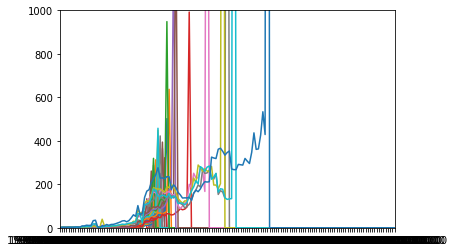

In [319]:
plt.plot(melt_df)
plt.axis([0, 150, 0, 0.1e4])
plt.show()

In [320]:
cd ../LGM27ka/

/Users/trackow/Documents/science-icebergs-lgm/LGM27ka


In [321]:
EXP='LGM27ka'

In [323]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/LGM27ka'

In [324]:
# use Weddell Sea icebergs only
weddell_idx=np.logical_and(DATA[:,1]>=-63., DATA[:,1]<=-50.)
poslat,poslon,areas=DATA[weddell_idx,0],DATA[weddell_idx,1],DATA[weddell_idx,2]
# all
#poslat,poslon,areas=DATA[:,0],DATA[:,1],DATA[:,2] 

lengths=np.sqrt(areas)*1000. # to meters
widths=lengths
heights=np.ones_like(poslon)*250. #0. # 250m
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00'] * num_buoys

# move positions 10 degrees eastwards
poslon=poslon+10.
#poslat=poslat+10.

num_buoys

111

In [325]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
#poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
#poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
#lengths=np.ones_like(poslon)*2000. #5000. # 1000m
#widths=np.ones_like(poslon)*2000. #5000. # 1000m
#heights=np.ones_like(poslon)*250. #0. # 250m

# config
initialdate='1900-01-01 12:00:00'
num_times=10*12*3 #10*12*3 #120   # number of iterations: integrate for x ...
delta_t=86400*10 #*30 #... days [time step in seconds]
#substeps=30
num_buoys=poslon.shape[0]
#start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

(111,)


,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.5122,315.5936,308.0017,314.2368,307.8533,313.3589,310.7969,307.299,309.3724,312.3709,...,309.3928,311.6255,309.3456,309.7535,310.6472,311.063,309.8118,309.6877,312.4398,310.9017


In [326]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [327]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_ocean_uv', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[38:40])

# get ssh slope
SSH = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=0. #-3.e-6
ddx[SSHnan==-9.e+33]=-3.e-6 # 0.

# get winds
Uafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent

# get sea ice velocity
Uicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICUO', returncoords=True, threeD=False)
Vicefield, XX, YY = loaddate_ofCOSMO(EXP+'_mpiom_last100year_SIC_velocity', 'SICVE', returncoords=True, threeD=False)
Uicefield[Uicefield==-9.e+33]=np.nan
Vicefield[Vicefield==-9.e+33]=np.nan
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #month=i % 12
    month=objects.getmonth_forcing()
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate sea ice velocity fields at buoy position
    Uicefield_flatten, Vicefield_flatten=Uicefield[month,:,:].flatten(),Vicefield[month,:,:].flatten()
    ui_ib, vi_ib=Uicefield_flatten[idx], Vicefield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    #sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # lock icebergs into the sea ice
    Asill=86. # Schodlok et al . [2006] 
    U[conci_ib>Asill],V[conci_ib>Asill]=ui_ib[conci_ib>Asill],vi_ib[conci_ib>Asill]
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    objects.compute_areas() # NEW
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    # append the iceberg volume loss
    melt_df.loc[objects.getdate()] = objects.volloss
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate][idx] = np.nan
lons_df

loading ./LGM27ka_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_ocean_uv_ymonmean_r360x180.nc ...
[17.  6.]
loading ./LGM27ka_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM27ka_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM27ka_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
loading ./LGM27ka_mpiom_last100year_SIC_velocity_ymonmean_r360x180.nc ...
This is loop #0


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30
This is loop #31
This is loop #32
This is loop #33
This is loop #34
This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39
This is loop #40
This is loop #41


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launc

This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This is loop #60
This is loop #61
This is loop #62
This is loop #63
This is loop #64
This is loop #65
This is loop #66
This is loop #67
This is loop #68
This is loop #69
This is loop #70
This is loop #71
This is loop #72
This is loop #73
This is loop #74
This is loop #75
This is loop #76
This is loop #77
This is loop #78
This is loop #79
This is loop #80
This is loop #81
This is loop #82
This is loop #83
This is loop #84
This is loop #85
This is loop #86
This is loop #87
This is loop #88
This is loop #89
This is loop #90
This is loop #91
This is loop #92
This is loop #93
This is loop #94
This is loop #95
This is loop #96
This is loop #97
This is loop #98
This is loop #99
This is loop #

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
1900-01-01 12:00:00,310.512200,315.593600,308.001700,314.236800,307.853300,313.358900,310.796900,307.299000,309.372400,312.370900,...,309.392800,311.625500,309.345600,309.753500,310.647200,311.063000,309.811800,309.687700,312.439800,310.901700
1900-01-11 12:00:00,310.478628,315.629735,307.962804,314.192858,307.814448,313.320457,310.762933,307.311747,309.360890,312.326327,...,309.395101,311.581284,309.322491,309.751473,310.622164,311.029010,309.809775,309.692527,312.408263,310.867667
1900-01-21 12:00:00,310.422630,315.702276,307.885418,314.105494,307.737151,313.244071,310.695428,307.337157,309.338007,312.237776,...,309.399675,311.493436,309.276563,309.747447,310.572416,310.961461,309.805751,309.695307,312.345625,310.800032
1900-01-31 12:00:00,310.345476,315.775058,307.730731,314.019148,307.582637,313.153840,310.628765,307.362398,309.315389,312.150385,...,309.404194,311.416786,309.231204,309.743471,310.513464,310.894755,309.801778,309.691324,312.270042,310.733242
1900-02-10 12:00:00,310.237177,315.847779,307.500485,314.013121,307.352647,313.050067,310.534420,307.387474,309.255154,312.045273,...,309.408661,311.322564,309.186399,309.739545,310.445543,310.800350,309.797855,309.687392,312.181853,310.638720
1900-02-20 12:00:00,310.119156,315.941039,307.243725,314.114514,307.341481,312.940598,310.400598,307.373624,309.147947,311.911324,...,309.433036,311.188914,309.172404,309.719301,310.387917,310.666445,309.777625,309.667116,312.088621,310.504652
1900-03-02 12:00:00,310.079083,316.054481,307.267354,314.243792,307.632074,312.906435,310.264142,307.321439,309.032093,311.767805,...,309.476766,311.044776,309.188446,309.683209,310.297916,310.522037,309.741557,309.630967,311.966409,310.360071
1900-03-12 12:00:00,309.930992,316.038587,307.606427,314.187065,307.997033,312.790984,310.028866,307.266603,308.800225,311.537209,...,309.514116,310.798746,309.184882,309.657938,310.156085,310.275552,309.716304,309.605657,311.808047,310.116610
1900-03-22 12:00:00,309.591088,315.894934,307.957575,313.947000,308.350917,312.516259,309.690627,307.209233,308.456416,311.222517,...,309.541323,310.454345,309.189954,309.629908,309.906774,309.933785,309.688292,309.577584,311.562986,309.777767
1900-04-01 12:00:00,309.506571,315.753363,308.308954,313.710810,308.350290,312.427109,309.607948,307.033324,308.428105,311.140145,...,309.564168,310.398836,309.221937,309.589409,309.565192,309.883286,309.647819,309.537026,311.248292,309.727606


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


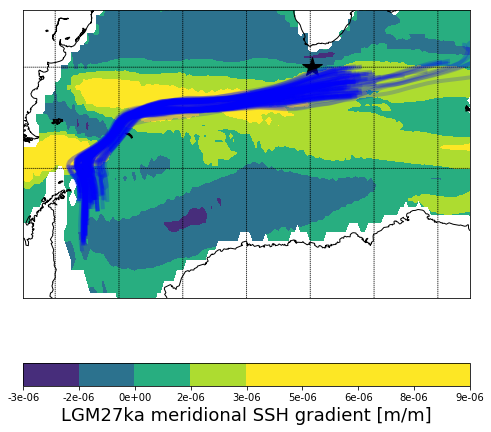

In [328]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
projectiontype='other'
#m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
projectiontype='merc'
m = Basemap(llcrnrlon=-70.,llcrnrlat=-75.,urcrnrlon=70.,urcrnrlat=-25.,\
            resolution='l',projection='merc',\
            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax)

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')


# shift XX for Mercator projection
lons_atm=np.copy(XX[0,:])
XX_shift=np.copy(XX)
XX_shift[XX>180.]=XX_shift[XX>180.]-360.

reorderlons = False
if projectiontype=='merc':
    reorderlons=True 

# -------------------------------------------------------------------- #
if reorderlons==True:
    # lons_atm: 0..360, lats_atm: 90..-90   
    lons_atm[lons_atm>=180]=lons_atm[lons_atm>=180]-360. # 0..180 -180..0
    # apply function lambda(x)=lons_atm[x] to [0..191] before sorting
    I=sorted(range(len(lons_atm)),key=lambda x:lons_atm[x])
    # reorder the longitudes and data
    XX_shift=XX_shift[:,I] 
    # lons_atm: -180..180
    
    lon_map,lat_map=m(XX_shift[:,1:],YY[:,1:])
    
else:
    lon_map,lat_map=m(XX[:,1:],YY[:,1:])

# plot meridional SSH gradient as background
cbar_label=EXP+" meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
#month=0
#plotfield=np.squeeze(ddy[month,:,:])
plotfield=np.squeeze(np.nanmean(ddy[0:12,:,:], axis=0))

# plot the field
if reorderlons==True:
    im=m.contourf(lon_map,lat_map,plotfield[:,I[1:]],vmin=vmin, vmax=vmax)
else:
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax.plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    if reorderlons:
        a[a>=180]=a[a>=180]-360. # 0..180 -180..0
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax.plot(lon_traj, lat_traj, 'b', lw=4, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax)
cbar.set_label(cbar_label, fontsize=18)

plt.show()

In [329]:
objects.volloss

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice


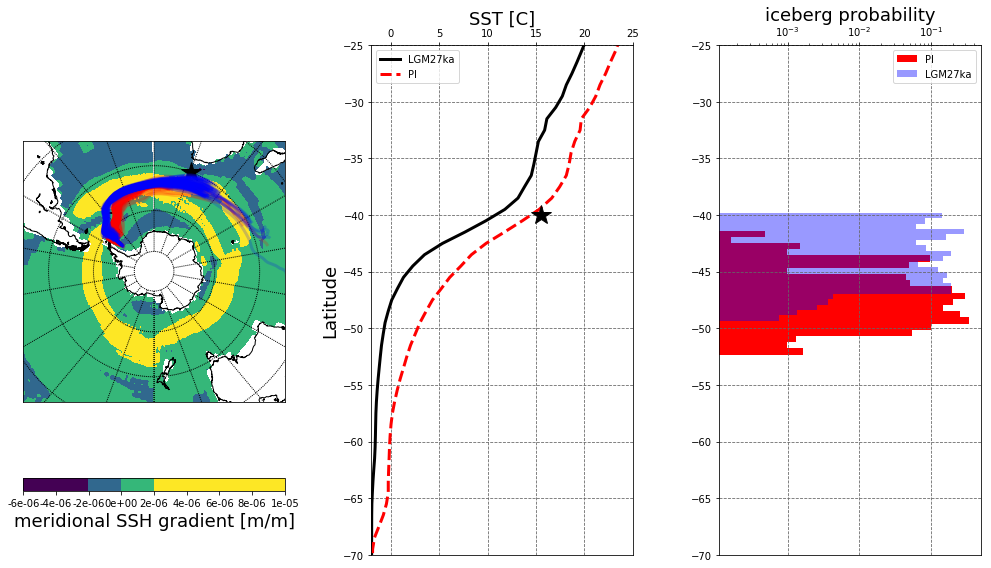

In [331]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(14,8))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
#m = Basemap(llcrnrlon=-80.,llcrnrlat=-75.,urcrnrlon=50.,urcrnrlat=-25.,\
#            resolution='l',projection='merc',\
#            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])
#shiftlons=False

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

#if shiftlons:
#    XX[XX>180.]=XX[XX>180.]-360.
lon_map,lat_map=m(XX[:,:],YY[:,:])

# plot SSH as background
#cbar_label='mean sea surface height [m]'
#vmin=-2.
#vmax=2.
#SSH[SSH==-9.e+33]=np.nan
#plotfield=np.mean(SSH,axis=0)

# set to nan; which month and level?
#cbar_label="surface temperature"
#month=0
#level=39
#vmin=-2.
#vmax=20.
#plotfield=potT[month,level,:,:]

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)

# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df_PI[buoynum][:].values, mask=np.isnan(lons_df_PI[buoynum][:].values))
    b = np.ma.array(lats_df_PI[buoynum][:].values, mask=np.isnan(lats_df_PI[buoynum][:].values))
    
    #if shiftlons:
    #    a[a>180.]=a[a>180.]-360.
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'r', lw=3, alpha=0.2)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    #if shiftlons:
    #    a[a>180.]=a[a>180.]-360.
        
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'b', lw=3, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
cbar.set_label(cbar_label, fontsize=18)


#############################
# SST as function of latitude
level=39 #surface
temp=np.nanmean(potT[:,level,:,:], axis=0)
agulhas=np.reshape(temp[np.logical_and(np.logical_and(XX<50.,XX>=0.),YY<-20.)], (70,50))
agulhas_zonalmean=np.nanmean(agulhas, axis=1)

x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
y=agulhas_zonalmean # SST
ax[1].plot(y,x,color='k', linestyle='-', label=EXP, lw=3)
#ax=plt.gca()
ax[1].xaxis.tick_top()
ax[1].set_xlabel(r'SST [C]', fontsize=18)    
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Latitude', fontsize=18)  

# plot PI value
ax[1].plot(agulhas_zonalmean_PI,x,color='r', linestyle='--', label='PI', lw=3)

# plot APcomp
x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
y_APcomp=15.5
ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
ax[1].set_ylim((-70,-25))
ax[1].set_xlim((-2,25))
ax[1].legend()

#ax[1].grid()
plt.rc('grid', linestyle="--", color='0.4')
ax[1].grid(True)

#plt.rc('grid', linestyle="--", color='0.4')

#####################
# PDF of iceberg latitudes in range 0-50E
normed=True
agulhas_positions=np.array(lats_df[np.logical_and(lons_df<50.,lons_df>=0.)]).flatten()
plt.rc('grid', linestyle="--", color='0.4')
ax[2].grid(True)
ax[2].hist(np.ma.masked_array(agulhas_positions_PI, mask=np.isnan(agulhas_positions_PI)),bins=20, normed=normed, color='red', orientation=u'horizontal', log=True, label='PI')
#ax[2].hist(np.ma.masked_array(agulhas_positions_LGM, mask=np.isnan(agulhas_positions_LGM)),bins=20, normed=normed, color='m', orientation=u'horizontal', log=True, label='LGM', alpha=0.4)
ax[2].hist(np.ma.masked_array(agulhas_positions, mask=np.isnan(agulhas_positions)),bins=20, normed=normed, color='b', orientation=u'horizontal', log=True, label=EXP, alpha=0.4)
ax[2].set_ylim((-70,-25))
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlabel('iceberg probability', fontsize=18)  
plt.legend()

plt.tight_layout()
plt.show()

In [332]:
np.sum(objects.L==0.)

111

In [210]:
lons_df.to_csv(EXP+'_6912lons_forAidan.csv')
lats_df.to_csv(EXP+'_6912lats_forAidan.csv')

In [211]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/LGM'

###### TO DO
- integrate the upper ocean in the end; deeper ocean before, might do a turn?!